## Description

In this notebook I am building a model with ExtraTreesClassifier, tuning it with GridSearchCV.

After that - I am using validation set to analyse the quality of model prediction and trying to remove some features to improve it


### Import DATA

In [1]:
import pandas as pd
import os
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
import multiprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler
import joblib

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
screenshots = pd.read_csv("./images/screenshots/screenshots.csv")

screenshots_ph = pd.read_csv("./images/screenshots_ph/screenshots_ph.csv")

receipts = pd.read_csv("./images/receipts/receipts.csv")

regulars = pd.read_csv("./images/regular/regular.csv")

not_good = pd.read_csv("./images/not_good/not_good.csv")

superb = pd.read_csv("./images/superb/superb.csv")

blinked = pd.read_csv("./images/blinked/blinked.csv")

docs = pd.read_csv("./images/docs/docs.csv")

test = pd.read_csv("./images/test/test.csv")


### Labeling and spliting

In [4]:
# from_labels = ["blinked", "docs", "not_good", "receipts", "regular", "screenshots", "screenshots_ph", "superb", "test"]

label = "screenshots_ph"

blinked[label] = 0
regulars[label] = 0
not_good[label] = 0
superb[label] = 0
screenshots[label] = 0
docs[label] = 0
screenshots_ph[label] = 1
receipts[label] = 0


whole_docs = pd.concat([regulars, not_good, superb, screenshots, docs, receipts, screenshots_ph], ignore_index=True)

In [5]:
whole_docs = whole_docs.drop(columns=["filename"])

In [6]:
whole_docs = whole_docs.fillna(0)

In [7]:
y = whole_docs.pop(label)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(whole_docs, y, test_size=0.15, random_state=42)

## Running on 4 Classifiers

### ExtraTree simple

In [9]:
import classifiers_3 as c3

In [10]:
search_scr = c3.extratrees_model(X_train, y_train, c3.param_et)

Fitting 10 folds for each of 324 candidates, totalling 3240 fits


Time taken to train the model: 3 minutes and 24.45 seconds
Best parameters: {'extratreesclassifier__min_samples_leaf': 1, 'extratreesclassifier__min_samples_split': 2, 'extratreesclassifier__n_estimators': 200}
Best score: 0.9687004280027537


### CatBoost

In [11]:
search_cb = c3.catboost_model(X_train, y_train, c3.param_cb)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Time taken to train the model: 11 minutes and 48.86 seconds
Best parameters: {'catboostclassifier__depth': 4, 'catboostclassifier__iterations': 350, 'catboostclassifier__l2_leaf_reg': 1e-20}
Best score: 0.9768160186764838


### LGBMClassifier

In [12]:
param_lgbm = {
        'n_estimators': range(100, 400, 50), 
        'num_leaves': range(20, 40, 5), 
        'min_child_samples': range(1, 20, 2)
}

search_lgbm = c3.lgbm_model(X_train, y_train, c3.param_lgbm)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits
[LightGBM] [Info] Number of positive: 154, number of negative: 2434
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13003
[LightGBM] [Info] Number of data points in the train set: 2588, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.059505 -> initscore=-2.760339
[LightGBM] [Info] Start training from score -2.760339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

### AdaBoost

In [13]:
param_adaboost = {
        'n_estimators': range(50, 400, 50), 
        'learning_rate': [0.01, 0.1, 1.0],
        'estimator__max_depth': [1, 2, 3]
}

search_ab = c3.adaboost_model(X_train, y_train, c3.param_adaboost)

Fitting 10 folds for each of 63 candidates, totalling 630 fits


Time taken to train the model: 8 minutes and 42.13 seconds
Best parameters: {'adaboostclassifier__estimator__max_depth': 3, 'adaboostclassifier__learning_rate': 0.1, 'adaboostclassifier__n_estimators': 300}
Best score: 0.9787450240938614


### All 4 classifiers comparison

In [14]:
best_score_et = search_scr.best_score_
best_score_lgbm = search_lgbm.best_score_
best_score_catboost = search_cb.best_score_
best_score_adaboost = search_ab.best_score_

# Create a list to display the results
results = [
    ('Extra Trees', best_score_et),
    ('CatBoost', best_score_catboost),
    ('LightGBM', best_score_lgbm),
    ('AdaBoost', best_score_adaboost)
]

# Print the results in a tabular format
print(f"{'Classifier':<15}{f'Best Score - {label}'}")
for name, score in results:
    print(f"{name:<15}{score:.4f}")

Classifier     Best Score - screenshots_ph
Extra Trees    0.9687
CatBoost       0.9768
LightGBM       0.9795
AdaBoost       0.9787


In [15]:
results = [search_scr, search_lgbm, search_cb, search_ab]

results_with_identifiers = [
    (search_scr, 'scr'),
    (search_lgbm, 'lgbm'),
    (search_cb, 'cb'),
    (search_ab, 'ab')
]

classifier_mapping = {
    'scr': 'ExtraTrees',
    'lgbm': 'LightGBM',
    'cb': 'CatBoost',
    'ab': 'AdaBoost'
}

named_steps_estimator = {
    'scr': 'extratreesclassifier',
    'lgbm': 'lgbmclassifier',
    'cb': 'catboostclassifier',
    'ab': 'adaboostclassifier'
}



best_model, best_identifier = results_with_identifiers[0]

for model, identifier in results_with_identifiers[1:]:
    if model.best_score_ > best_model.best_score_:
        best_model = model
        best_identifier = identifier

# Use best_identifier to get the classifier name from the mapping
classifier_name = classifier_mapping.get(best_identifier, 'Unknown')
nsteps = named_steps_estimator.get(best_identifier)

## Confusion matrix

In [16]:
filenames = test.pop("filename")
label

'screenshots_ph'

In [17]:
prediction = best_model.predict(test)

result = pd.DataFrame()
result['filename'] = filenames
result['prediction'] = prediction

result.loc[(result.prediction == 1) & (result.filename.str.contains(label)), "metric"] = "true"
result.loc[(result.prediction == 0) & (result.filename.str.contains(label)), "metric"] = "FN"
result.loc[(result.prediction == 0) & (~result.filename.str.contains(label)), "metric"] = "not true"
result.loc[(result.prediction == 1) & (~result.filename.str.contains(label)), "metric"] = "FP"

result.groupby("metric").count()

,filename,prediction
metric,,
FN,3,3
FP,2,2
not true,87,87
true,2,2


In [18]:
result.loc[result.metric == "FP"]

,filename,prediction,metric
35,docs (16).JPG,1,FP
42,screenshot_ph.JPG,1,FP


#### Confusion matrix representation

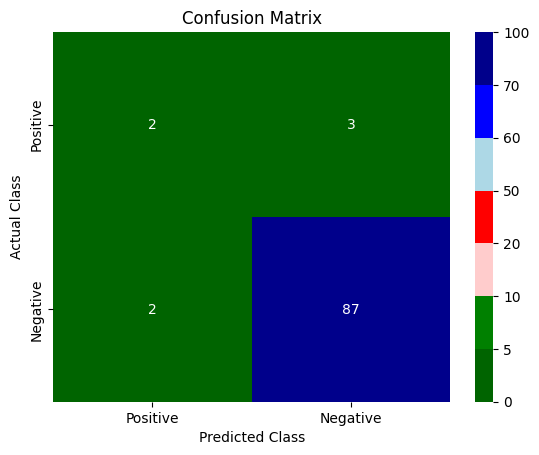

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define your color boundaries and corresponding colors
boundaries = [0, 5, 10, 20, 50, 60, 70, 100]  # Assuming 80 is your max value
colors = [
    'darkgreen',  # 0-5
    'green',      # 5-10
    '#ffcccc',    # 10-20 (light red)
    'red',        # 20-50
    'lightblue',  # 50-60
    'blue',       # 60-70
    'darkblue'    # above 70
]

# Create a colormap
custom_cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries, custom_cmap.N, clip=True)


tp = sum(result['metric'] == 'true')  
fn = sum(result['metric'] == 'FN')    
tn = sum(result['metric'] == 'not true')  
fp = sum(result['metric'] == 'FP') 

conf_matrix = np.array([[tp, fn],
                        [fp, tn]])

# You can then plot this using seaborn or matplotlib
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_cmap, norm=norm, 
            xticklabels=['Positive', 'Negative'], 
            yticklabels=['Positive', 'Negative'])
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix')
plt.show()

__________________

In [20]:
from sklearn.feature_selection import RFECV

In [21]:
%%time
best_estimator = best_model.best_estimator_
search_RFE = RFECV(best_estimator.named_steps[nsteps], cv=10, scoring="accuracy", n_jobs = multiprocessing.cpu_count() - 1, verbose=3)
search_RFE.fit(X_train, y_train)
prediction = search_RFE.predict(test)

result = pd.DataFrame()
result['filename'] = filenames
result['prediction'] = prediction

result.loc[(result.prediction == 1) & (result.filename.str.contains(label)), "metric"] = "true"
result.loc[(result.prediction == 0) & (result.filename.str.contains(label)), "metric"] = "FN"
result.loc[(result.prediction == 0) & (~result.filename.str.contains(label)), "metric"] = "not true"
result.loc[(result.prediction == 1) & (~result.filename.str.contains(label)), "metric"] = "FP"

result.groupby("metric").count()

Fitting estimator with 57 features.
[LightGBM] [Info] Number of positive: 154, number of negative: 2434
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13003
[LightGBM] [Info] Number of data points in the train set: 2588, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.059505 -> initscore=-2.760339
[LightGBM] [Info] Start training from score -2.760339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

,filename,prediction
metric,,
FN,3,3
FP,3,3
not true,86,86
true,2,2


## Saving the model

In [22]:
model_path = f"./models/{label}_final_{classifier_name}.model"
joblib.dump(search_RFE, model_path)

print(f"Model saved successfully at {model_path}")

Model saved successfully at ./models/screenshots_ph_final_LightGBM.model
